In [ ]:
#from google.colab import drive
#drive.mount('/content/drive')

In [11]:
import numpy as np
import math
import matplotlib.pyplot as plt
import pandas as pd
import re
import random
from sklearn.model_selection import train_test_split

from konlpy.tag import Mecab
from tqdm import tqdm


import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import *
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,  ReduceLROnPlateau
from tensorflow.keras.regularizers import *
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.optimizers import *
import tensorflow.keras.backend as K
from datetime import datetime
from sklearn.model_selection import train_test_split

In [12]:
def clean_text(text):
    
    text = text.lower()
    text = re.sub(r'[^가-힣a-z\s]', ' ', text)
    text = ' '.join(text.split())
    
    return text

In [25]:
#train = pd.read_csv('/content/drive/MyDrive/DLthon_data/train3.csv')
#test = pd.read_json('/content/drive/MyDrive/DLthon_data/test.json').transpose()
#submission = pd.read_csv('/content/drive/MyDrive/DLthon_data/new_submission.csv')

train = pd.read_csv('/aiffel/aiffel/dktc/train3.csv')
Test = pd.read_json('/aiffel/aiffel/dktc/data/test.json').transpose()
submission = pd.read_csv('/aiffel/aiffel/dktc/data/new_submission.csv')

label_dict = {
    '협박 대화': 0,
    '갈취 대화': 1,
    '직장 내 괴롭힘 대화': 2,
    '기타 괴롭힘 대화': 3,
    '일반 대화':4
}
train['label_encoded'] = train['class'].map(label_dict)

In [26]:
train['conversation'] = train['conversation'].apply(clean_text)
Test['text'] = Test['text'].apply(clean_text)

In [27]:
train = train[['conversation','label_encoded']]
train = train.rename(columns = {'label_encoded':'class'})

In [28]:
#불용어
stopwords = [
        '이', '있', '하', '것', '들', '그', '되', '수', '이', '보', '않', '없', '나', '사람', '주', '아니',
        '등', '같', '우리', '때', '년', '가', '한', '지', '대하', '오', '말', '일', '그렇', '위하',
        '때문', '그것', '두', '말하', '알', '그러나', '받', '못하', '일', '그런', '또', '문제', '더', '사회',
        '많', '그리고', '좋', '크', '따르', '중', '나오', '가지', '씨', '시키', '만들', '지금', '생각하',
        '그러', '속', '하나', '집', '살', '모르', '적', '월', '데', '자신', '안', '어떤', '내', '내', '경우',
        '명', '생각', '시간', '그녀', '다시', '이런', '앞', '보이', '번', '나', '다른', '어떻', '여자', '개',
        '전', '들', '사실', '이렇', '점', '싶', '말', '정도', '좀', '원', '잘', '통하', '소리', '놓'
    ]

In [35]:
X_train = []
y_train = to_categorical(np.array(train['class']))

conversation = list(train['conversation'])

mecab = Mecab()
for i in tqdm(range(len(conversation))):
    temp_x = []
    temp_x = mecab.morphs(conversation[i])#토큰화
    temp_x = [word for word in temp_x if not word in stopwords]
    temp_x = [word for word in temp_x if len(word)>1]
    X_train.append(temp_x)

100%|██████████| 4906/4906 [00:03<00:00, 1346.15it/s]


In [36]:
test = []

text = list(Test['text'])

for i in tqdm(range(len(text))):
    temp_x = []
    temp_x = mecab.morphs(text[i])#토큰화
    temp_x = [word for word in temp_x if not word in stopwords]
    temp_x = [word for word in temp_x if len(word)>1]
    test.append(temp_x)

100%|██████████| 500/500 [00:00<00:00, 1526.07it/s]


In [38]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [41]:
total_cnt = len(tokenizer.word_index) #단어의 수
vocab_size = total_cnt+1

In [42]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
test = tokenizer.texts_to_sequences(test)

In [43]:
X_train = pad_sequences(X_train,maxlen=300)
test = pad_sequences(test,maxlen=300)

In [44]:
class MultiHeadAttention(Layer):
    def __init__(self, embedding_dim, num_heads=8):
        super(MultiHeadAttention, self).__init__()
        self.embedding_dim = embedding_dim # d_model
        self.num_heads = num_heads

        assert embedding_dim % self.num_heads == 0

        self.projection_dim = embedding_dim // num_heads
        self.query_dense = Dense(embedding_dim)
        self.key_dense = Dense(embedding_dim)
        self.value_dense = Dense(embedding_dim)
        self.dense = Dense(embedding_dim)
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'embedding_dim' : self.embedding_dim,
            'num_heads' : self.num_heads,
            
            'projection_dim' : self.projection_dim,
            'query_dense' : self.query_dense,
            'key_dense' : self.key_dense,
            'value_dense' : self.value_dense,
            'dense' : self.dense
        })

    def scaled_dot_product_attention(self, query, key, value):
        matmul_qk = tf.matmul(query, key, transpose_b=True)
        depth = tf.cast(tf.shape(key)[-1], tf.float32)
        logits = matmul_qk / tf.math.sqrt(depth)
        attention_weights = tf.nn.softmax(logits, axis=-1)
        output = tf.matmul(attention_weights, value)
        return output, attention_weights

    def split_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]

        # (batch_size, seq_len, embedding_dim)
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)

        # (batch_size, num_heads, seq_len, projection_dim)
        query = self.split_heads(query, batch_size)  
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)

        scaled_attention, _ = self.scaled_dot_product_attention(query, key, value)
        # (batch_size, seq_len, num_heads, projection_dim)
        scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])  

        # (batch_size, seq_len, embedding_dim)
        concat_attention = tf.reshape(scaled_attention, (batch_size, -1, self.embedding_dim))
        outputs = self.dense(concat_attention)
        return outputs

In [45]:
class TransformerBlock(Layer):
    def __init__(self, embedding_dim, num_heads, dff, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadAttention(embedding_dim, num_heads)
        self.ffn = Sequential(
            [Dense(dff, activation="relu"),
             Dense(embedding_dim),]
        )
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'att' : self.att,
            'ffn' : self.ffn,
            'layernorm1' : self.layernorm1,
            'layernorm2' : self.layernorm2,
            'dropout1' : self.dropout1,
            'dropout2' : self.dropout2
        })

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [46]:
class TokenAndPositionEmbedding(Layer):
    def __init__(self, max_len, vocab_size, embedding_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(vocab_size, embedding_dim)
        self.pos_emb = Embedding(max_len, embedding_dim)
        
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'token_emb' : self.token_emb,
            'pos_emb' : self.pos_emb,
        })
        return config

    def call(self, x):
        max_len = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=max_len, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [53]:
max_len = 300
embedding_dim = 32
num_heads = 4
dff = 32

inputs = Input(shape=(max_len,))
embedding_layer = TokenAndPositionEmbedding(max_len, vocab_size, embedding_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embedding_dim, num_heads, dff)
x = transformer_block(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(8, activation="relu")(x)
x = Dropout(0.1)(x)
outputs = Dense(5, activation="softmax")(x)

model = Model(inputs=inputs, outputs=outputs)

In [54]:
import os
import numpy as np
from sklearn.metrics import f1_score
from keras.callbacks import Callback, ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences

class F1ScoreCallback(Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data

    def on_epoch_end(self, epoch, logs=None):
        val_predict = (np.asarray(self.model.predict(self.validation_data[0]))).round()
        val_targ = self.validation_data[1]
        _val_f1 = f1_score(val_targ, val_predict, average='macro')
        print(f' — val_f1: {_val_f1:.4f}')
        logs['val_f1'] = _val_f1

In [55]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [64]:
# 모델 컴파일
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# 체크포인트 콜백
ckpt_1 = 'tf_chkpoint.ckpt'
path = 'aiffel/aiffel/dktc/'  # 체크포인트 저장 경로를 적절히 설정하세요
mc = ModelCheckpoint(filepath=os.path.join(path, ckpt_1), monitor='val_accuracy', save_best_only=True, mode='max', verbose=1, save_weights_only=True)

# F1-score 콜백
f1_callback = F1ScoreCallback(validation_data=(X_val, y_val))

# 모델 훈련
history = model.fit(X_train, y_train, batch_size=32, epochs=30, validation_data=(X_val, y_val), callbacks=[mc, f1_callback])

Epoch 1/30
99/99 [==============================] - 3s 17ms/step - loss: 0.0458 - accuracy: 0.9863 - val_loss: 1.2917 - val_accuracy: 0.8357

Epoch 00001: val_accuracy improved from -inf to 0.83567, saving model to aiffel/aiffel/dktc/tf_chkpoint.ckpt
 — val_f1: 0.8364
Epoch 2/30
99/99 [==============================] - 1s 13ms/step - loss: 0.0344 - accuracy: 0.9869 - val_loss: 1.3391 - val_accuracy: 0.8357

Epoch 00002: val_accuracy did not improve from 0.83567
 — val_f1: 0.8371
Epoch 3/30
99/99 [==============================] - 1s 13ms/step - loss: 0.0225 - accuracy: 0.9892 - val_loss: 1.3901 - val_accuracy: 0.8357

Epoch 00003: val_accuracy did not improve from 0.83567
 — val_f1: 0.8384
Epoch 4/30
99/99 [==============================] - 1s 13ms/step - loss: 0.0292 - accuracy: 0.9879 - val_loss: 1.5580 - val_accuracy: 0.8293

Epoch 00004: val_accuracy did not improve from 0.83567
 — val_f1: 0.8330
Epoch 5/30
99/99 [==============================] - 1s 13ms/step - loss: 0.0364 - accu

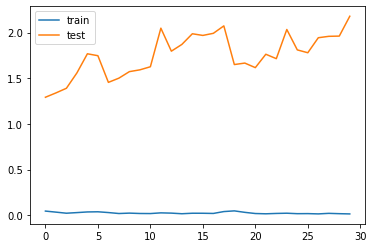

In [65]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()


In [66]:
y_pred = model.predict(test)

submission['class'] = np.argmax(y_pred, axis=-1)
submission.head(10)

,file_name,class
0,t_000,1
1,t_001,2
2,t_002,2
3,t_003,2
4,t_004,3
5,t_005,0
6,t_006,0
7,t_007,1
8,t_008,2
9,t_009,1


In [67]:
submission.to_csv('transformer.csv',index=False)

In [ ]:
#에폭3:0.4
#에폭 20 :0.626
#에폭 30:0.628